Company XYZ is an Online Travel Agent, such as Expedia, Booking.com, etc.

They store their data in JSON ﬁles. Each row in the json shows all diﬀerent cities which have been searched for by a user within the same session (as well as some other info about the user). That is, if I go to company XYZ site and look for hotels in NY and SF within the same session, the corresponding JSON row will show my user id, some basic info about me and the two cities.

# Index
* [Load and clean data](#Load-and-clean-data)
* [Answer question 1](#Answer-question-1)
* [Answer question 2](#Answer-question-2)
* [Answer question 3](#Answer-question-3)

In [1]:
import itertools
from collections import Counter
import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

## Load and clean data

In [2]:
def clean_json(d):
    """
    clean the json data, make the data easier to be processed
    """
    assert len(d['cities']) == 1
    d['cities'] = d['cities'][0]

    assert len(d['session_id']) == 1
    d['session_id'] = d['session_id'][0]

    assert len(d['unix_timestamp']) == 1
    d['timestamp'] = datetime.datetime.utcfromtimestamp(d['unix_timestamp'][0])
    del d['unix_timestamp']

    # -------- retrieve users
    user_dict = d['user']

    assert len(user_dict) == 1
    user_dict = user_dict[0]

    assert len(user_dict) == 1
    user_dict = user_dict[0]

    d['user_id'] = user_dict['user_id']
    d['user_country'] = user_dict['country']

    del d['user']
    return d

In [3]:
with open("city_search.json",'rt') as inf:
    sessions = json.load(inf)
    
for d in sessions:
    clean_json(d)

sessions = pd.DataFrame(sessions)
sessions = sessions.set_index('session_id')

In [4]:
sessions.tail()# get a feeling about the data

,cities,timestamp,user_country,user_id
session_id,,,,
17WJGZOEFEI4W,"Chicago IL, Montreal QC",2015-05-02 05:40:04,,4360
9HCZDQMGU5Z2G,Chicago IL,2015-06-16 08:46:00,IT,2057
73ZWORX75Y9A0,Chicago IL,2015-08-03 06:47:50,IT,1203
DMWGV9HY74G9T,"Calgary AB, New York NY",2015-06-25 12:31:31,ES,3699
TVJS9Z6EZDPEA,San Jose CA,2015-05-07 09:03:13,DE,2375


In [5]:
# empty string will be treated as NA when read back
# and some function will dropna=True by default
# so give those missing countries another tag
sessions.loc[sessions.user_country == '','user_country'] = 'Missing'

In [6]:
sessions.tail()

,cities,timestamp,user_country,user_id
session_id,,,,
17WJGZOEFEI4W,"Chicago IL, Montreal QC",2015-05-02 05:40:04,Missing,4360
9HCZDQMGU5Z2G,Chicago IL,2015-06-16 08:46:00,IT,2057
73ZWORX75Y9A0,Chicago IL,2015-08-03 06:47:50,IT,1203
DMWGV9HY74G9T,"Calgary AB, New York NY",2015-06-25 12:31:31,ES,3699
TVJS9Z6EZDPEA,San Jose CA,2015-05-07 09:03:13,DE,2375


## Answer question 1
There was a bug in the code and one country didn't get logged. It just shows up as an empty ﬁeld (""). Can you guess which country was that? How?

my basic idea to solve this problem is <span style='color:orange;font-size:1.5em'>checking the 'searching time' habit of each country. the time difference can give us some hint about the geographic location of each country.</span>

In [7]:
# count the statistics about each hour and its ratio in a certain country
hours_by_country = sessions.groupby("user_country").apply(lambda df: df.timestamp.dt.hour.value_counts(normalize=True)).unstack(fill_value=0)

In [8]:
hours_by_country

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
user_country,,,,,,,,,,,,,,,,,,,,,
DE,0.000000,0.000000,0.000825,0.002749,0.007971,0.020341,0.041781,0.075591,0.107752,0.107752,...,0.090159,0.075591,0.046729,0.019791,0.009346,0.003573,0.001100,0.000000,0.000000,0.000000
ES,0.000000,0.000000,0.000000,0.002560,0.010241,0.023041,0.047107,0.082437,0.100358,0.111111,...,0.086022,0.068612,0.038914,0.020993,0.006656,0.002560,0.000000,0.000512,0.000000,0.000000
FR,0.000000,0.000000,0.000435,0.000435,0.005222,0.024369,0.050479,0.071802,0.092689,0.102698,...,0.094865,0.079199,0.045692,0.019147,0.007398,0.003916,0.001305,0.000000,0.000000,0.000000
IT,0.000000,0.000000,0.001594,0.002657,0.012221,0.019129,0.049416,0.074920,0.093518,0.108395,...,0.088735,0.078108,0.050478,0.021785,0.012221,0.002657,0.000000,0.000000,0.000000,0.000000
Missing,0.011348,0.031206,0.058865,0.090780,0.097872,0.104255,0.103546,0.095035,0.100355,0.100000,...,0.004610,0.001418,0.000355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UK,0.000000,0.000000,0.000000,0.001688,0.005345,0.009283,0.020534,0.046414,0.076231,0.091139,...,0.103797,0.102954,0.067792,0.050070,0.020253,0.005626,0.001688,0.000281,0.000281,0.000000
US,0.046440,0.027348,0.010578,0.002838,0.000774,0.000516,0.000258,0.000000,0.000000,0.000258,...,0.047472,0.071723,0.091589,0.109907,0.097265,0.106811,0.092105,0.093395,0.090557,0.066305


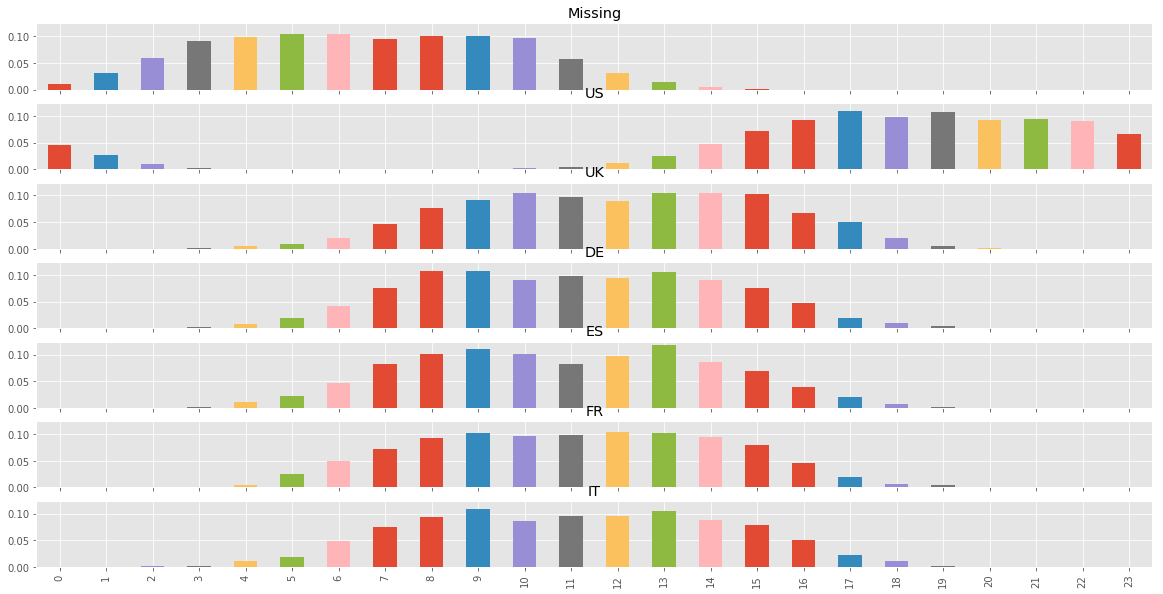

In [10]:
# plot the bar plot about search time ~ ratio
countries = ['Missing','US','UK','DE', 'ES', 'FR', 'IT']
fig,axes = plt.subplots(len(countries),1,sharex=True, sharey=True)
fig.set_size_inches(20,10)
for ax,country in zip(axes,countries):
    hours_by_country.loc[country,:].plot(kind='bar',ax=ax)
    ax.set_title(country)

from above plot, we can see that, "the searching time" habit of the "Missing" and US are very different from 'UK','DE', 'ES', 'FR', 'IT'. ** so 'Missing' country, like US, cannot be in Europe **. 

also from the plot above, ** the Missing country has a time difference about 11~12 hours with US **. 

based on above two facts, I guess the Missing country is in Asia, and it must have good economic to allow people to travel aboard. <span style='color:orange;font-size:1.5em'>Hence, I guess the Missing country may be China, Japan or South Korean</span>.

## Answer question 2
For each city, ﬁnd the most likely city to be also searched for within the same session.

my basic idea to solve this problem is:
1. model each city as a vector. i-th value in the vector represents #search by i-th user
2. then calculate cosine similarity between any two city vectors, get a similarity matrix
3. similarity[i,j] represents the similarity between i-th and j-th city
4. sort i-th row or column to get the top similar cities with i-th city

In [11]:
sessions['cities'] = sessions.cities.str.split(', ')
def count_cities(df):
    c = Counter(city for cities in df.cities for city in cities)
    return pd.Series(c)
searchcity_by_user = sessions.groupby("user_id").apply(count_cities).unstack(fill_value=0)

In [12]:
searchcity_by_user.shape

(5777, 89)

In [13]:
searchcity_by_user = searchcity_by_user.transpose()

In [14]:
searchcity_by_user.head()

user_id,4,5,9,10,11,13,15,17,18,20,...,10972,10973,10977,10979,10980,10981,10982,10988,10990,11000
Anaheim CA,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Arlington TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atlanta GA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Austin TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bakersfield CA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# make each row unit-norm, then dot-product is equivalent to cosine
searchcity_by_user_normed = normalize(searchcity_by_user,axis=1)

In [16]:
city_similarity = searchcity_by_user_normed.dot(searchcity_by_user_normed.T)
city_similarity = pd.DataFrame(city_similarity,
                               index = searchcity_by_user.index,
                               columns = searchcity_by_user.index)

In [17]:
city_similarity.head()

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
Anaheim CA,1.000000,0.033731,0.026082,0.037796,0.019139,0.038984,0.000000,0.047099,0.029180,0.077773,...,0.022195,0.118564,0.000000,0.018019,0.092873,0.037937,0.014494,0.026239,0.0,0.013199
Arlington TX,0.033731,1.000000,0.000000,0.243935,0.015064,0.036820,0.000000,0.037070,0.007655,0.040808,...,0.017469,0.058240,0.000000,0.113455,0.061675,0.039812,0.000000,0.020652,0.0,0.020777
Atlanta GA,0.026082,0.000000,1.000000,0.013801,0.000000,0.028470,0.494872,0.017198,0.017758,0.025817,...,0.020261,0.030704,0.051434,0.000000,0.037092,0.015392,0.000000,0.023953,0.0,0.000000
Austin TX,0.037796,0.243935,0.013801,1.000000,0.000000,0.045383,0.000000,0.039876,0.020587,0.062354,...,0.023489,0.132595,0.014907,0.019069,0.096751,0.049071,0.015339,0.013884,0.0,0.027937
Bakersfield CA,0.019139,0.015064,0.000000,0.000000,1.000000,0.010446,0.000000,0.037860,0.013031,0.012630,...,0.044603,0.038303,0.000000,0.048280,0.038883,0.022589,0.000000,0.000000,0.0,0.035366


In [19]:
### find top K most similar of each city
def most_similar(s,topk):
    # [0] must be itself
    similar_ones = s.sort_values(ascending=False)[1:topk+1].index.values
    return pd.Series(similar_ones,index = ["similar#{}".format(i) for i in range(1,topk+1)])

most_similar_cities = city_similarity.apply(most_similar,topk=1,axis=1)

In [20]:
most_similar_cities.sample(20)# check the result

,similar#1
Jacksonville FL,Tampa FL
Louisville KY,Lexington KY
Greensboro NC,Charlotte NC
San Jose CA,Oakland CA
London ON,Kitchener ON
WASHINGTON DC,Baltimore MD
Long Beach CA,Santa Ana CA
San Antonio TX,Austin TX
Philadelphia PA,New York NY
Birmingham AL,Atlanta GA


In [21]:
most_similar_cities.to_csv("most_similar_cities.csv")

## Answer question 3
Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The ﬁrst ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

In [22]:
sessions["num_searched"] = sessions.cities.map(len)

In [23]:
sessions.tail()# glance the data

,cities,timestamp,user_country,user_id,num_searched
session_id,,,,,
17WJGZOEFEI4W,"[Chicago IL, Montreal QC]",2015-05-02 05:40:04,Missing,4360,2
9HCZDQMGU5Z2G,[Chicago IL],2015-06-16 08:46:00,IT,2057,1
73ZWORX75Y9A0,[Chicago IL],2015-08-03 06:47:50,IT,1203,1
DMWGV9HY74G9T,"[Calgary AB, New York NY]",2015-06-25 12:31:31,ES,3699,2
TVJS9Z6EZDPEA,[San Jose CA],2015-05-07 09:03:13,DE,2375,1


In [28]:
def search_distance(cities,similar2dist):
    """
    input: 
        cities: a list of cities included in the search
        similar2dist: a function which maps similarity to distance
    return: 
        distance: distance among cities in the search
    """
    sumdist = 0
    total = len(cities)

    # if total=1, then distance =0
    for i1 in range(total-1):
        city1 = cities[i1]

        for i2 in range(i1+1,total):
            city2 = cities[i2]

            similarity = city_similarity.loc[city1,city2]
            dist = similar2dist(similarity)

            sumdist += dist

    # if there are n cities in the search, sum will be calculated 0.5*n*(n-1) times
    # then the distance biased too much to search which contains many cities
    # so I decide to divide 'n', then the distance is O(n) instead of O(n2)
    # which is more fair, but also takes account of "more city in the search, more likely to be irrelevant"
    return sumdist / total

In [29]:
distances = sessions.cities.map(lambda cities: search_distance(cities,lambda s: np.sqrt(1-s*s)))
# distances = sessions.cities.map(lambda cities: search_distance(cities,lambda s: 1-s*s))

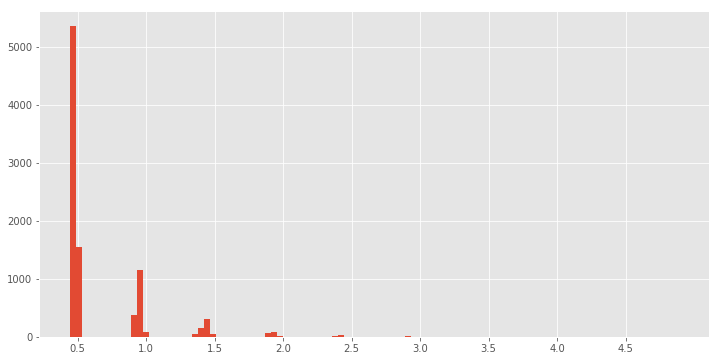

In [31]:
plt.xticks(np.arange(0,5,0.5))
# filter out distance=0, because a lot of search with one city will have distance=0
distances[distances>0].hist(bins=100,figsize=(12,6))

according to above plot, I decide to choose <span style='color:orange;font-size:1.5em'>distance=0.7 as the cutoff between 'high intent search' and 'low intent search'</span>. if the distance is higher than 0.7, then I classify such search as 'low intent'.

In [33]:
dist_cutoff = 0.9
print ('percentage of low intent search: {:.2f}%'.format((distances>dist_cutoff).mean() * 100))

percentage of low intent search: 12.21%


In [34]:
low_intent_search = sessions.loc[distances>dist_cutoff,['num_searched','cities']]

In [35]:
low_intent_search

,num_searched,cities
session_id,,
5AZ2X2A9BHH5U,3,"[New York NY, Jersey City NJ, Philadelphia PA]"
7BQ7VDHTZYRPD,3,"[Vancouver BC, Victoria BC, Seattle WA]"
IGWYW7VQBR7BW,3,"[Phoenix AZ, Chandler AZ, Mesa AZ]"
EEBNPTA77L6YT,4,"[San Antonio TX, Corpus Christi TX, Arlington ..."
5HILT84J9UF4W,4,"[Calgary AB, Seattle WA, Victoria BC, Portland..."
JHLZIXZPC77JW,3,"[San Diego CA, Toronto ON, New York NY]"
ACZVRMUYETZK8,3,"[San Jose CA, Stockton CA, Sacramento CA]"
1L8PSKKA9NFMR,3,"[Phoenix AZ, Glendale AZ, Chandler AZ]"
JU7DBPB9Y4OHS,3,"[Phoenix AZ, Los Angeles CA, Chicago IL]"
